In [1]:
# Setup plotting
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('animation', html='html5')

/tmp/ipykernel_11100/2426236682.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GroupShuffleSplit

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks

spotify = pd.read_csv('/home/tebrigabby/python/data_files/spotify (1).csv')

X = spotify.copy().dropna()
y = X.pop('track_popularity')
artists = X['track_artist']

features_num = ['danceability', 'energy', 'key', 'loudness', 'mode',
                'speechiness', 'acousticness', 'instrumentalness',
                'liveness', 'valence', 'tempo', 'duration_ms']
features_cat = ['playlist_genre']

preprocessor = make_column_transformer(
    (StandardScaler(), features_num),
    (OneHotEncoder(), features_cat),
)

# We'll do a "grouped" split to keep all of an artist's songs in one
# split or the other. This is to help prevent signal leakage.
def group_split(X, y, group, train_size=0.75):
    splitter = GroupShuffleSplit(train_size=train_size)
    train, test = next(splitter.split(X, y, groups=group))
    return (X.iloc[train], X.iloc[test], y.iloc[train], y.iloc[test])

X_train, X_valid, y_train, y_valid = group_split(X, y, artists)

X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)
y_train = y_train / 100 # popularity is on a scale 0-100, so this rescales to 0-1.
y_valid = y_valid / 100

input_shape = [X_train.shape[1]]
print("Input shape: {}".format(input_shape))

Input shape: [18]


In [3]:
# The group_split() function performs a grouped split on the data. This means that all of the songs by the same artist are kept in the 
# same split. This is done to help prevent signal leakage. Signal leakage is a problem that can occur when the training and validation 
# sets are not independent of each other. In this case, if the songs by the same artist are in different splits, then the model could 
# learn to predict the popularity of a song based on the artist, rather than the actual features of the song.

# The reason there are separate features and the processor is because the make_column_transformer() function allows you to specify 
# different transformers for different columns. In this case, we are using a StandardScaler() for the numerical features and a 
# OneHotEncoder() for the categorical features.

# The StandardScaler() normalizes the numerical features so that they have a mean of 0 and a standard deviation of 
# 1. This helps to improve the performance of the model.

# The OneHotEncoder() converts the categorical features into a one-hot encoded representation. This means that each category is 
# represented by a binary vector. This allows the model to learn the relationships between the different categories.

Minimum Validation Loss: 0.2023


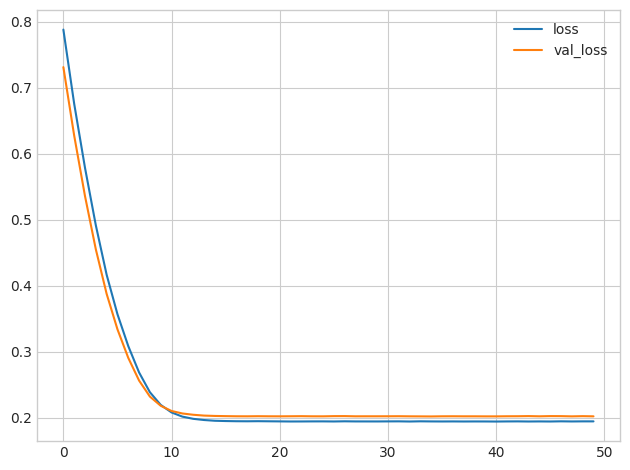

In [4]:
# Let's start with the simplest network, a linear model. This model has low capacity.
model = keras.Sequential([
    layers.Dense(1, input_shape=input_shape),
])
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
    verbose=0, # suppress output since we'll plot the curves
)
history_df = pd.DataFrame(history.history)
history_df.loc[0:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

Minimum Validation Loss: 0.2023


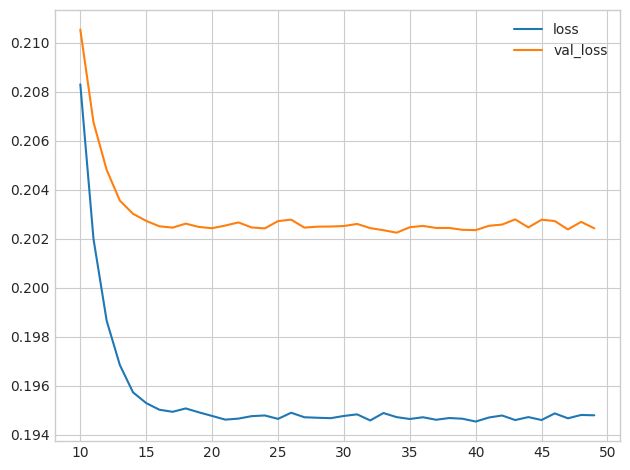

In [5]:
# It's not uncommon for the curves to follow a "hockey stick" pattern like you see here. This makes the final part of training hard to see, 
# so let's start at epoch 10 instead:

# Start the plot at epoch 10
history_df.loc[10:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

In [6]:
'''The gap between these curves is quite small and the validation loss never increases, so it's more likely that the network is underfitting than overfitting. It would be worth experimenting with more capacity to see if that's the case.'''

"The gap between these curves is quite small and the validation loss never increases, so it's more likely that the network is underfitting than overfitting. It would be worth experimenting with more capacity to see if that's the case."

Epoch 1/50
49/49 [==============================] - 6s 44ms/step - loss: 0.2590 - val_loss: 0.2179
Epoch 2/50
49/49 [==============================] - 1s 30ms/step - loss: 0.2030 - val_loss: 0.2087
Epoch 3/50
49/49 [==============================] - 1s 28ms/step - loss: 0.1976 - val_loss: 0.2075
Epoch 4/50
49/49 [==============================] - 1s 30ms/step - loss: 0.1954 - val_loss: 0.2082
Epoch 5/50
49/49 [==============================] - 2s 32ms/step - loss: 0.1938 - val_loss: 0.2056
Epoch 6/50
49/49 [==============================] - 2s 36ms/step - loss: 0.1934 - val_loss: 0.2034
Epoch 7/50
49/49 [==============================] - 2s 33ms/step - loss: 0.1914 - val_loss: 0.2020
Epoch 8/50
49/49 [==============================] - 2s 35ms/step - loss: 0.1900 - val_loss: 0.2043
Epoch 9/50
49/49 [==============================] - 1s 25ms/step - loss: 0.1895 - val_loss: 0.2010
Epoch 10/50
49/49 [==============================] - 2s 34ms/step - loss: 0.1888 - val_loss: 0.2045
Epoch 11/

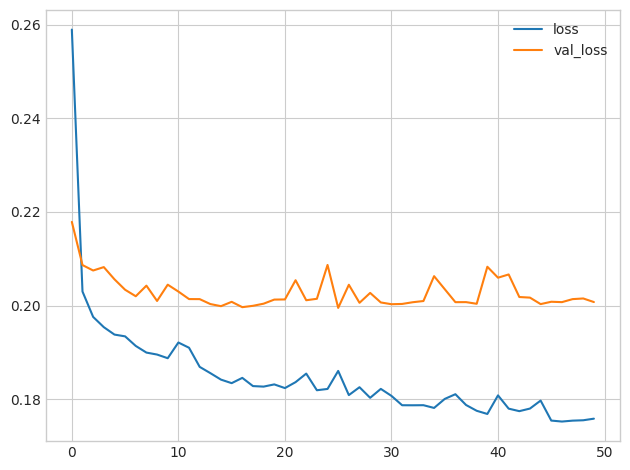

In [8]:
# Now let's add some capacity to our network. We'll add three hidden layers with 128 units each.

model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

In [10]:
#  Add Capacity
# Now the validation loss begins to rise very early, while the training loss continues to decrease. 
# This indicates that the network has begun to overfit. At this point, we would need to try something to prevent it, 
# either by reducing the number of units or through a method like early stopping.

In [11]:
# Define Early Stopping Callback
# Now define an early stopping callback that waits 5 epochs (patience') for a change in validation loss of at least 0.001 (min_delta) 
# and keeps the weights with the best loss (restore_best_weights).

from tensorflow.keras import callbacks

# YOUR CODE HERE: define an early stopping callback
early_stopping = callbacks.EarlyStopping(
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
)


Epoch 1/50
49/49 [==============================] - 5s 36ms/step - loss: 0.2563 - val_loss: 0.2141
Epoch 2/50
49/49 [==============================] - 1s 24ms/step - loss: 0.2039 - val_loss: 0.2074
Epoch 3/50
49/49 [==============================] - 2s 34ms/step - loss: 0.2010 - val_loss: 0.2056
Epoch 4/50
49/49 [==============================] - 1s 31ms/step - loss: 0.1969 - val_loss: 0.2057
Epoch 5/50
49/49 [==============================] - 2s 31ms/step - loss: 0.1960 - val_loss: 0.2046
Epoch 6/50
49/49 [==============================] - 2s 34ms/step - loss: 0.1943 - val_loss: 0.2033
Epoch 7/50
49/49 [==============================] - 2s 36ms/step - loss: 0.1925 - val_loss: 0.2028
Epoch 8/50
49/49 [==============================] - 2s 31ms/step - loss: 0.1900 - val_loss: 0.2026
Epoch 9/50
49/49 [==============================] - 2s 35ms/step - loss: 0.1908 - val_loss: 0.2013
Epoch 10/50
49/49 [==============================] - 2s 37ms/step - loss: 0.1898 - val_loss: 0.2019
Epoch 11/

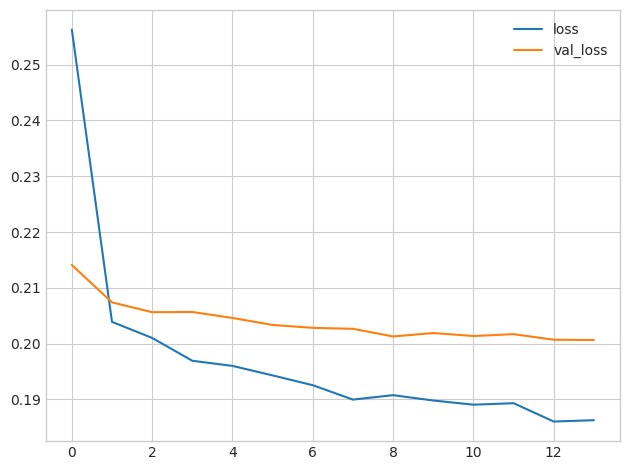

In [12]:
# get the learning curves. Notice the callbacks argument in model.fit.

model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dense(64, activation='relu'),    
    layers.Dense(1)
])
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
    callbacks=[early_stopping]
)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

In [13]:
# The early stopping callback did stop the training once the network began overfitting. Moreover, by including 
# restore_best_weights we still get to keep the model where validation loss was lowest.